# Project 6: SPICE

## RC Filter Circuit

In [1]:
from vpython import *
import math
import numpy as np
import matplotlib.pyplot as plt
import heapq, time

<IPython.core.display.Javascript object>

In [2]:
R = 1e3             # 1 kΩ
C = 1e-6            # 1 µF
Vin_amplitude = 5.0 # 1 V amplitude
frequencies = [10, 160, 10000]
dt = 1e-5           # Time step (10 µs)
T = 0.05            # Total simulation time (50 ms)
timesteps = int(T / dt)
t = np.linspace(0, T, timesteps)

In [3]:
def RCFilter(freq):
    omega = 2 * np.pi * freq
    Vin = Vin_amplitude * np.sin(omega * t)

    # Initialize arrays
    Vout = np.zeros_like(t)
    G = C / dt
    Icap_prev = 0

    for i in range(1, len(t)):
        # Vin(t) goes through R into node Vout with parallel capacitor
        Icap = G * Vout[i-1]  # equivalent current source from cap
        Vout[i] = (Vin[i] / R + Icap) / (1 / R + G)

    return Vin, Vout

In [4]:
results = {}
for freq in frequencies:
    Vin, Vout = RCFilter(freq)
    results[freq] = (Vin, Vout)

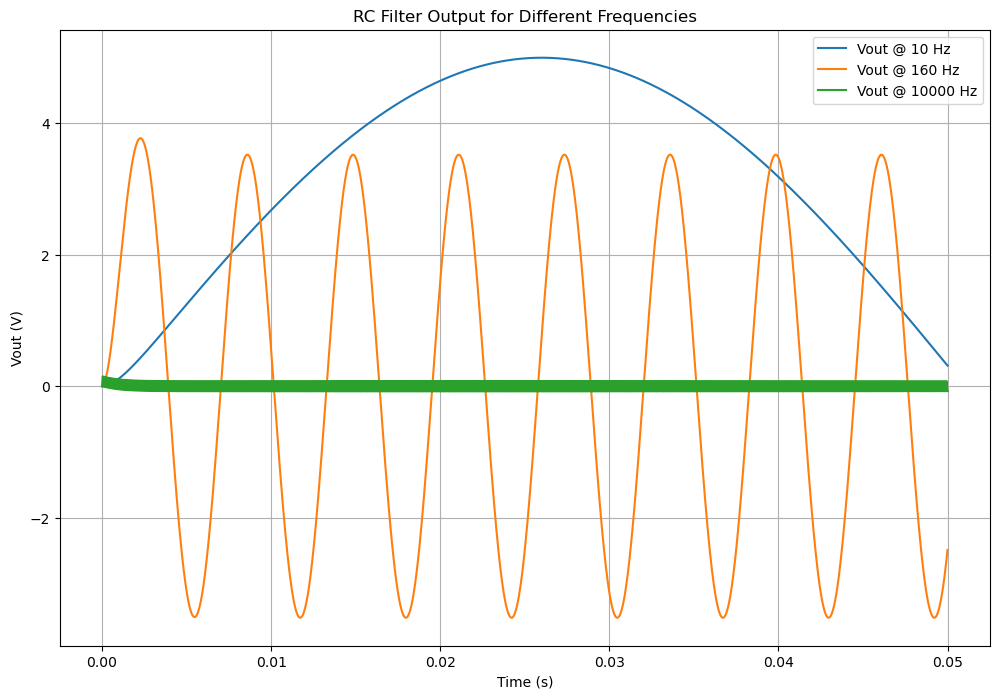

In [5]:
plt.figure(figsize=(12, 8))
for freq in frequencies:
    plt.plot(t, results[freq][1], label=f'Vout @ {freq} Hz')
plt.xlabel('Time (s)')
plt.ylabel('Vout (V)')
plt.title('RC Filter Output for Different Frequencies')
plt.legend()
plt.grid(True)
plt.show()

### Assumptions

Using a resistance of 1000 ohm and a capacitance of 1 microF, we can calculate the cutoff frequency using the equation f = 1/(2piRC). This gives a cutoff frequency of about 159 Hz. The low cutoff frequency allows us to easily test a wide range of frequency ranges. A 1 microF capacitor and a 1000 ohm resistor are very common values in circuits.

I chose the time constant to be 10 microseconds because the time constant needs to balance the simulation speed and provide enough data for the graph. At 10kHz, one period is 100 microseconds which gives 10 points per cycle. For the simulation length, I chose 50 ms becuase that would provide us with, at minimum, 5 cycles for each frequency. Lastly, the frequencies 10 Hz, 160 Hz, and 10000 Hz were chosen becuase they are below, at, and above the cut off frequency,

### Results

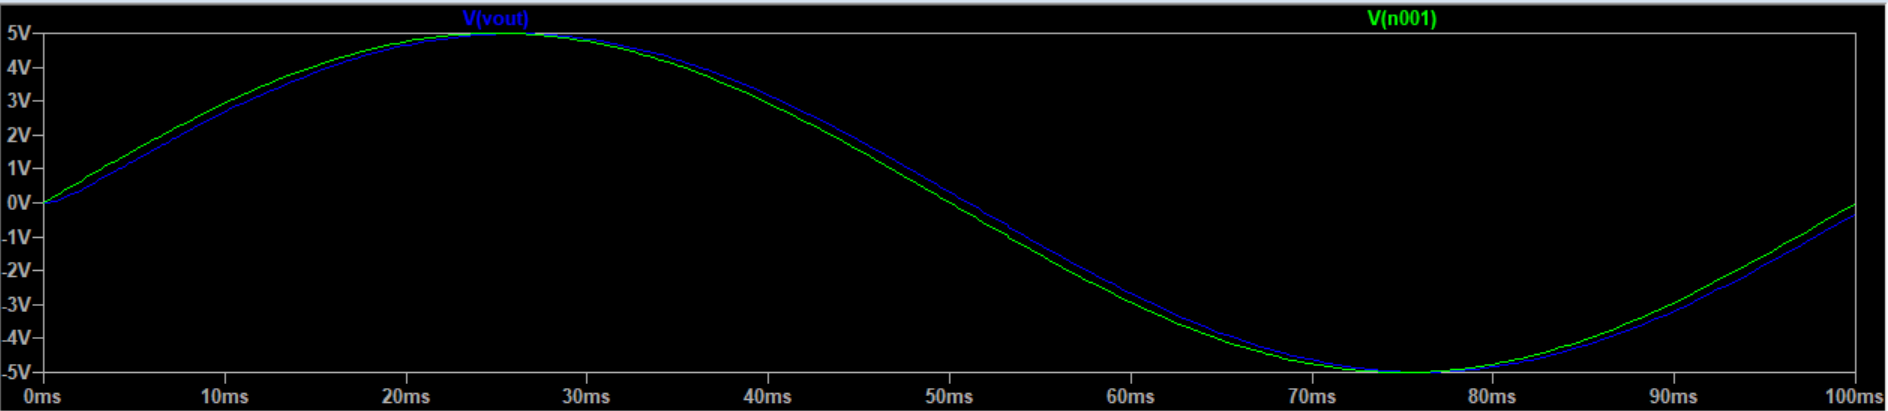

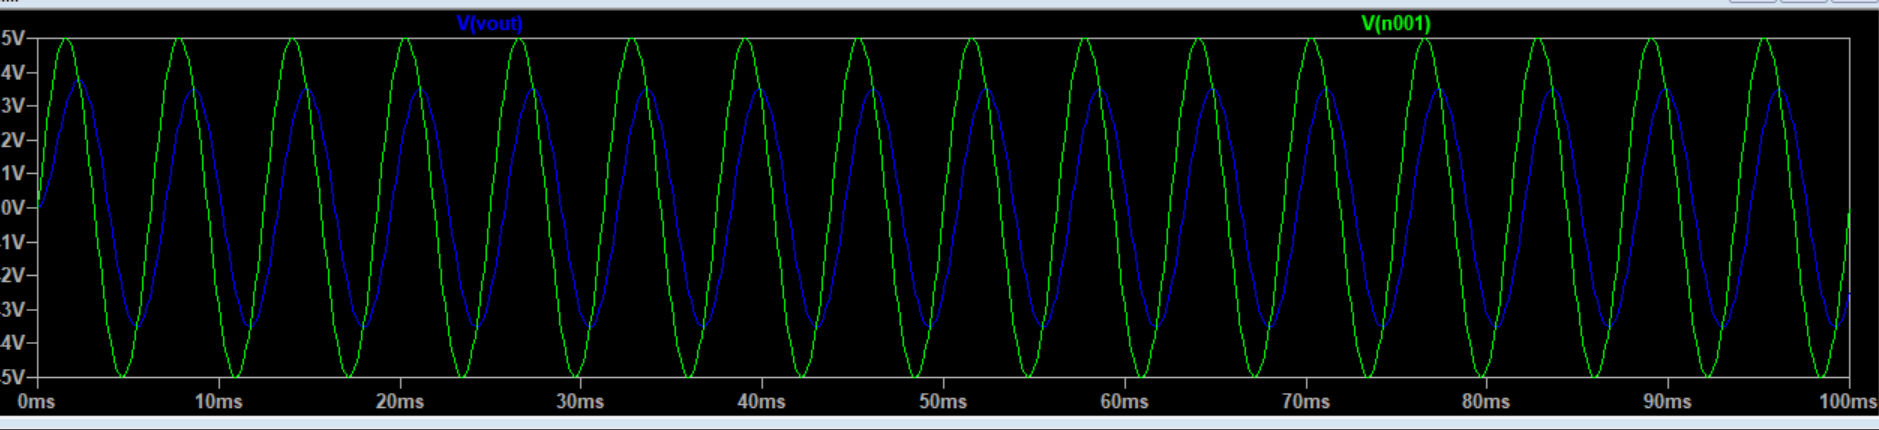

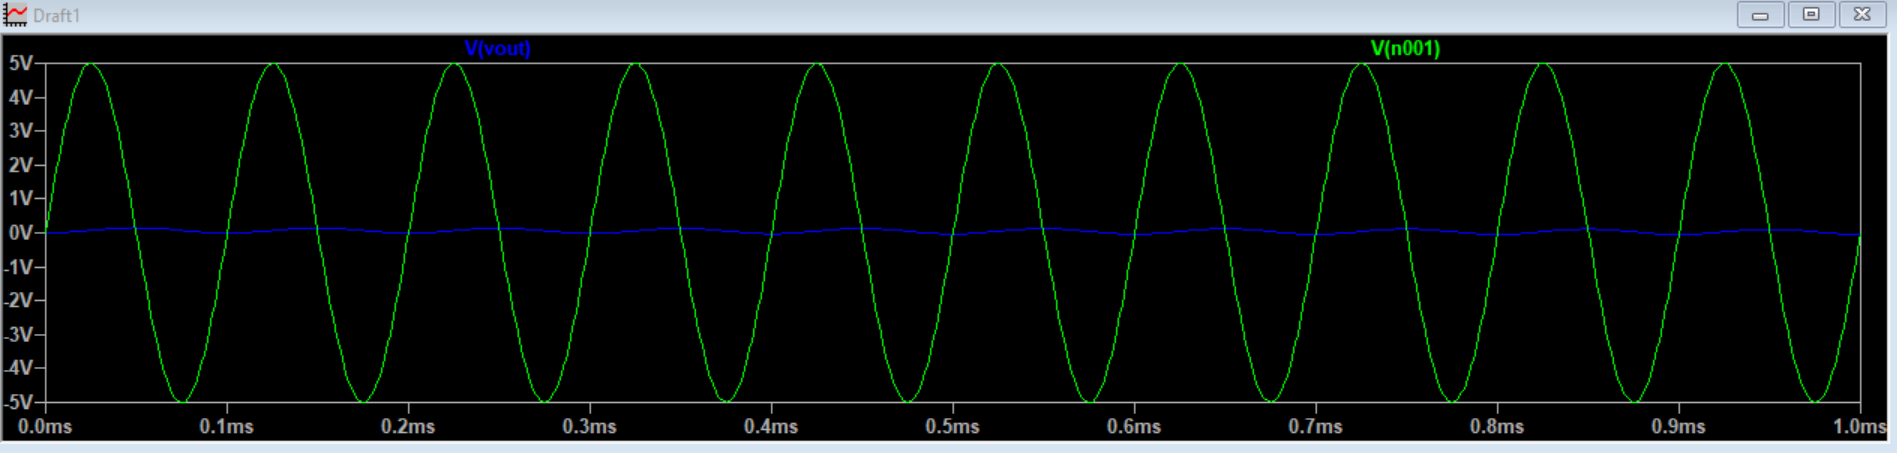

At 10 Hz, the output voltage peaks at 5V and oscillates to -5V. We can see by the graph generated that the graph has large curve and does not oscillate quickly. This verifies the results we got above.

At 160 Hz, we can see that the output voltage of the RC circuit is approximately 3.5V. In addition, the generated graph can be seen in the bottom corner where it oscillates between 3.5 V and -3.5V which verifies the results that we got above.

At 10kHz, the output voltage oscillates between 80 mV and -80mV which is very close to 0. In our graph above, our voltage at 10kHz appears to oscillate at 0 V. The graph in the simulation looks very similar to the graph we generated and verifies the results we got above.

## Half Wave Rectifier Circuit

In [6]:
# Constants for the 1N4148 Diode
I_s = 1e-14  # Saturation current (A)
V_T = 25.85e-3  # Thermal voltage (V)
n = 1  # Ideality factor

# Circuit Parameters
R = 1e3  # Load resistor (Ohms)
V_peak = 5  # Peak voltage (V)
f = 60  # Frequency (Hz)
dt = 1e-4  # Time step (s)
sim_time = 0.1  # Simulation time (s)

# Time array
t = np.arange(0, sim_time, dt)
V_in = V_peak * np.sin(2 * np.pi * f * t)  # Input AC voltage (sinusoidal)

# Initialize arrays to store results
V_d = np.zeros_like(t)  # Diode voltage (V)
I_d = np.zeros_like(t)  # Diode current (A)
V_out = np.zeros_like(t)  # Output voltage across load resistor (V)

# Initial guess for diode voltage
V_d_guess = 0.7  # Initial guess for diode forward voltage (V)

In [7]:
# Function to calculate current through the diode based on the linear model
def diode_current(V_d):
    G_d = I_s * np.exp(V_d / (n * V_T)) / (n * V_T)  # Conductance (S)
    I_d = I_s * (np.exp(V_d / (n * V_T)) - 1)  # Diode current (A)
    return I_d, G_d

# Newton-Raphson method for diode voltage
def diodeVoltage(V_d_guess, I_in):
    max_iter = 10  # Maximum number of iterations
    tolerance = 1e-6  # Convergence tolerance
    
    for _ in range(max_iter):
        I_d, G_d = diode_current(V_d_guess)  # Current and conductance
        F = I_d - I_in  # Diode current minus input current
        F_prime = G_d  # Derivative of the current with respect to V_d
        
        # Update voltage using Newton-Raphson
        delta_V_d = F / F_prime
        V_d_guess -= delta_V_d
        
        if abs(delta_V_d) < tolerance:
            break
    
    return V_d_guess

In [8]:
# Simulation loop
for i in range(1, len(t)):
    I_in = np.maximum(V_in[i] / R, 0)  # Current from the input source (diode only conducts for positive voltage)
    V_d[i] = diodeVoltage(V_d_guess, I_in)  # Update diode voltage using Newton-Raphson method
    I_d[i], _ = diode_current(V_d[i])  # Calculate diode current
    
    # Output voltage is the voltage across the load resistor
    if V_in[i] > V_d[i]:  # Diode is forward biased
        V_out[i] = V_in[i] - V_d[i]  # Output voltage is the input voltage minus the diode voltage
    else:  # Diode is reverse biased (no current)
        V_out[i] = 0  # Output voltage is zero when the diode does not conduct

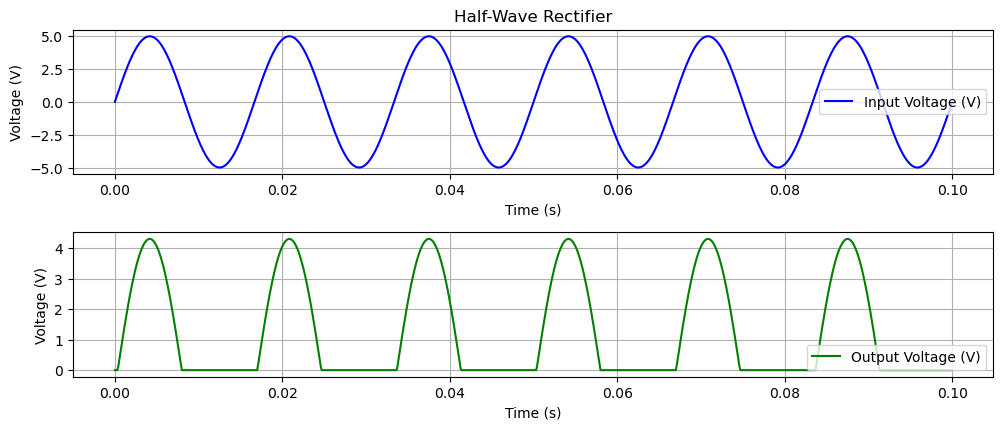

In [9]:
# Plot the results
plt.figure(figsize=(10, 6))

# Plot Input Voltage
plt.subplot(3, 1, 1)
plt.plot(t, V_in, label='Input Voltage (V)', color='b')
plt.title('Half-Wave Rectifier')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.grid(True)
plt.legend()

# Plot Output Voltage (across the resistor)
plt.subplot(3, 1, 2)
plt.plot(t, V_out, label='Output Voltage (V)', color='g')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

### Assumptions

The diode chosen for simulation was the 1N4148 diode. The diode parameters match that of the 1N4148 and using 10ohm for the signal resistance will simplify convergence. Once again, I chose to use a 1000 ohm resistor as that is most commonly used in circuits. The amplitude of 5V allows for a wider range of data and makes the graph easier to read. I chose 60Hz for the input voltage as that will allow us to see many cycles over a short period of time. The time step being 0.1 ms will balance the simulation speed and give more accurate data. Lastly, the simulation length being 0.1s allows us to have about six cycles.

### Results

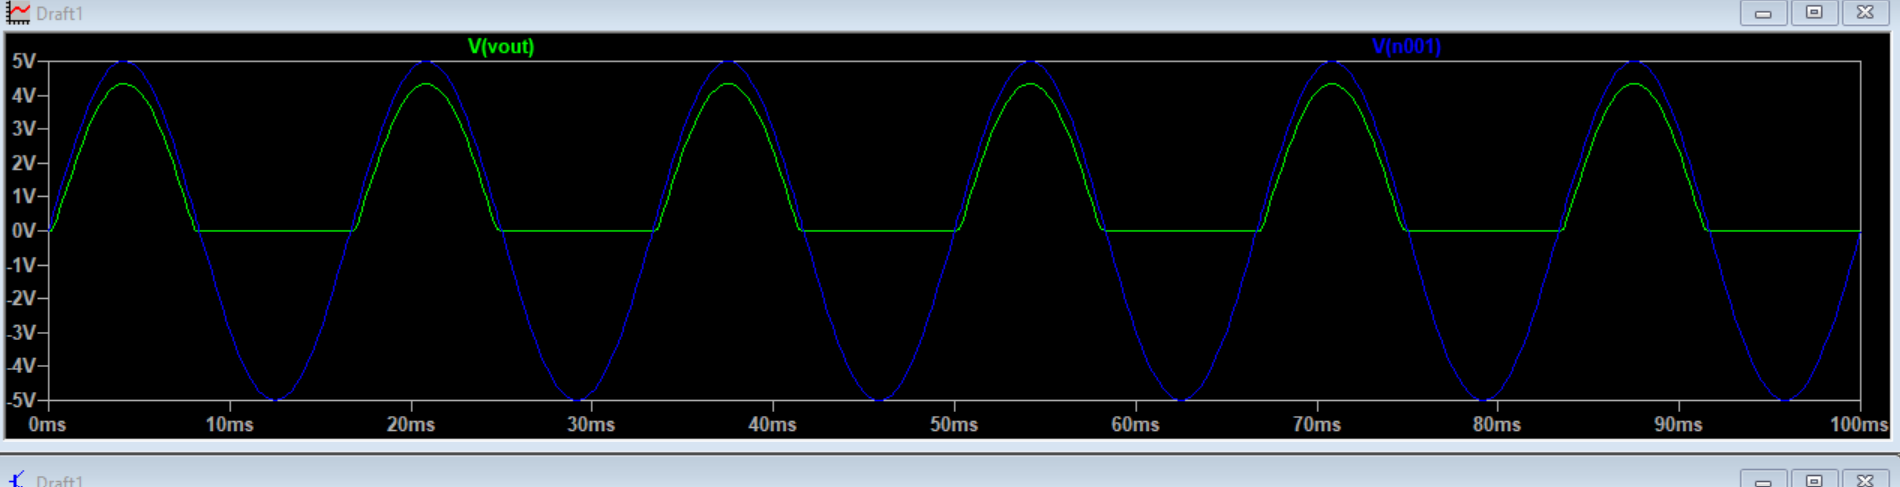

The calculated graph shows that each interval does return back to 0V as the LTSpice simulation does. In addition, both graphs show that in each interval the output voltage peaks when the input voltage peaks, and they follow the oscillation pattern of the voltage input. Both peak at a little less than 5V.

Decreasing the resistance to 10 ohms caused the voltage output to only peak at around 0.5~0.75 V. The output voltage also remains to be a half wave rectifier and not oscillate past 0 V.

Using a small time step like, 0.1 ms, results in reliable convergence becuase the diode's operating point is very close to the previous one. This also results in more data points which makes the simulation and graphs more accurate. Using a time step of 0.1 ms the waveform is sampled around 167 times per cycle. A higher time step than 0.1 ms could result in less accurate results as the diode data may not be recorded correctly. 